# TimeSeries Deep Encoder
This notebook walks through how to use Darts' `TiDEModel` and benchmarks it against `NHiTSModel`.

TiDE (Time-series Dense Encoder) is a pure DL encoder-decoder architecture. It is special in that the temporal decoder can help mitigate the effects of anomalous samples on a forecast (Fig. 4 in the paper).

See the original paper and model description here: [http://arxiv.org/abs/2304.08424](http://arxiv.org/abs/2304.08424).

In [1]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [2]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import torch
import numpy as np
import pandas as pd
import shutil

from darts.models import NHiTSModel, TiDEModel
from darts.datasets import AusBeerDataset
from darts.dataprocessing.transformers.scaler import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.metrics import mae, mse

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

/opt/homebrew/Caskroom/miniforge/base/envs/darts-dev/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


# Model Parameter Setup
Boilerplate code is no fun, especially in the context of training multiple models to compare performance. To avoid this, we use a common configuration that can be used with any Darts `TorchForecastingModel`.

A few interesting things about these parameters:

- **Gradient clipping:** Mitigates exploding gradients during backpropagation by setting an upper limit on the gradient for a batch.

- **Learning rate:** The majority of the learning done by a model is in the earlier epochs. As training goes on it is often helpful to reduce the learning rate to fine-tune the model. That being said, it can also lead to significant overfitting.

- **Early stopping:** To avoid overfitting, we can use early stopping. It monitors a metric on the validation set and stops training once the metric is not improving anymore based on a custom condition.

In [5]:
optimizer_kwargs = {
    "lr": 1e-3,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
    "callbacks": [],
    "precision": "32-true",
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    "input_chunk_length": 12,  # lookback window
    "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    "likelihood": None,  # use a likelihood for probabilistic forecasts
    "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

# Data Loading and preparation
We consider the Australian quarterly beer sales in megaliters. 

Before training, we split the data into train, validation, and test sets. The model will learn from the train set, use the validation set to determine when to stop training, and finally be evaluated on the test set.

To avoid leaking information from the validation and test sets, we scale the data based on the properties of the train set.

In [6]:
series = AusBeerDataset().load()

train, temp = series.split_after(0.6)
val, test = temp.split_after(0.5)

<Axes: xlabel='date'>

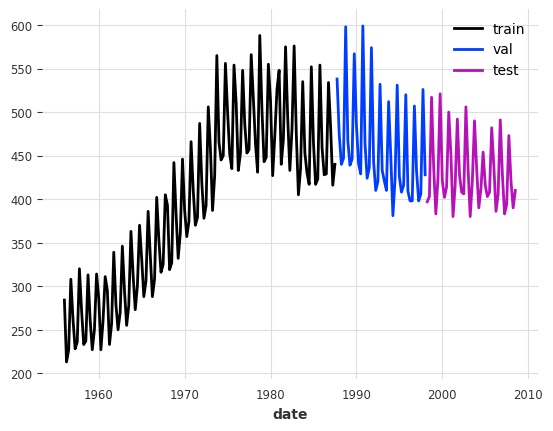

In [7]:
train.plot(label="train")
val.plot(label="val")
test.plot(label="test")

In [8]:
scaler = Scaler()  # default uses sklearn's MinMaxScaler
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

# Model configuration
Using the already established shared arguments, we can see that the default parameters for NHiTS and TiDE are used. The only exception is that TiDE is tested both with and without [Reversible Instance Normalization](https://openreview.net/forum?id=cGDAkQo1C0p).

We then iterate through the model dictionary and train all of the models. When using early stopping it is important to save checkpoints. This allows us to continue past the best model configuration and then restore the optimal weights once training has been completed.

In [9]:
# create the models
model_nhits = NHiTSModel(**common_model_args, model_name="hi")

model_tide = TiDEModel(
    **common_model_args, use_reversible_instance_norm=False, model_name="tide0"
)

model_tide_rin = TiDEModel(
    **common_model_args, use_reversible_instance_norm=True, model_name="tide1"
)

models = {
    "NHiTS": model_nhits,
    "TiDE": model_tide,
    "TiDE+RIN": model_tide_rin,
}

In [ ]:
# train the models and load the model from its best state/checkpoint
for name, model in models.items():

    # early stopping needs to get reset for each model
    pl_trainer_kwargs["callbacks"] = [
        EarlyStopping(
            **early_stopping_args,
        )
    ]

    model.fit(
        series=train,
        val_series=val,
        verbose=True,
    )
    # load from checkpoint returns a new model object, we store it in the models dict
    models[name] = model.load_from_checkpoint(model_name=model.model_name, best=True)

In [ ]:
# we will predict the next `pred_steps` points after the end of `pred_input`
pred_steps = common_model_args["output_chunk_length"] * 2
pred_input = test[:-pred_steps]
pred_input = pred_input.astype(np.float32)

fig, ax = plt.subplots(figsize=(15, 5))
pred_input.plot(label="input")
test[-pred_steps:].plot(label="ground truth", ax=ax)

In [ ]:
result_accumulator = {}
# predict with each model and compute/store the metrics against the test sets
for model_name, model in models.items():
    pred_series = model.predict(n=pred_steps, series=pred_input)
    pred_series.plot(label=model_name, ax=ax)

    result_accumulator[model_name] = {
        "mae": mae(test, pred_series),
        "mse": mse(test, pred_series),
    }

# Results
In this case, vanilla TiDE is similarly accurate as NHiTs. Including reversible instance normalization (`RINorm`) drastically helped to improve the TiDE forecasts (Keep in mind that this is just an example, and it is not always guaranteed to improve performance).

In [ ]:
results_df = pd.DataFrame.from_dict(result_accumulator, orient="index")
results_df.plot.bar()

In [ ]:
results_df = pd.DataFrame.from_dict(result_accumulator, orient="index")
results_df.plot.bar()

# Torch compile

In [51]:
optimizer_kwargs = {
    "lr": 1e-3,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
    "callbacks": [],
    "precision": "32-true",
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    "input_chunk_length": 12,  # lookback window
    "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    "likelihood": None,  # use a likelihood for probabilistic forecasts
    "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    "force_reset": True,
    "batch_size": 8,
    "random_state": 42,
    "num_encoder_layers": 8,
    "num_decoder_layers": 8,
    "decoder_output_dim": 64,
    "hidden_size": 1024,
}

In [52]:
train = train.astype(np.float32)
val = val.astype(np.float32)

In [53]:
common_model_args["pl_trainer_kwargs"]["max_epochs"] = 10

In [54]:
model_tide_compiled = TiDEModel(
    **common_model_args,
    use_reversible_instance_norm=True,
    model_name="tide_compiled",
    compile_model=True,
    compile_model_kwargs={
        "backend": "aot_eager" if torch.backends.mps.is_available() else "inductor",
    }
)

In [55]:
%%time

# pl_trainer_kwargs["callbacks"] = [
#     EarlyStopping(
#         **early_stopping_args,
#     )
# ]

model_tide_compiled.fit(
    series=train,
    val_series=val,
    verbose=True,
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

CPU times: user 22 s, sys: 5.91 s, total: 27.9 s
Wall time: 52.9 s


TiDEModel(output_chunk_shift=0, num_encoder_layers=8, num_decoder_layers=8, decoder_output_dim=64, hidden_size=1024, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, compile_model=True, compile_model_kwargs={'backend': 'aot_eager'}, input_chunk_length=12, output_chunk_length=12, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 10, 'accelerator': 'auto', 'callbacks': [], 'precision': '32-true'}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, likelihood=None, save_checkpoints=True, force_reset=True, batch_size=8, random_state=42, use_reversible_instance_norm=True, model_name=tide_compiled)

In [56]:
model_tide_not_compiled = TiDEModel(
    **common_model_args,
    use_reversible_instance_norm=True,
    model_name="tide_not_compiled",
    compile_model=False,
)

In [57]:
%%time

# pl_trainer_kwargs["callbacks"] = [
#     EarlyStopping(
#         **early_stopping_args,
#     )
# ]

model_tide_not_compiled.fit(
    series=train,
    val_series=val,
    verbose=True,
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

CPU times: user 20.4 s, sys: 5.59 s, total: 26 s
Wall time: 44 s


TiDEModel(output_chunk_shift=0, num_encoder_layers=8, num_decoder_layers=8, decoder_output_dim=64, hidden_size=1024, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, compile_model=False, compile_model_kwargs=None, input_chunk_length=12, output_chunk_length=12, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 10, 'accelerator': 'auto', 'callbacks': [], 'precision': '32-true'}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, likelihood=None, save_checkpoints=True, force_reset=True, batch_size=8, random_state=42, use_reversible_instance_norm=True, model_name=tide_not_compiled)

In [ ]:
pred_steps = common_model_args["output_chunk_length"] * 2
pred_input = test[:-pred_steps]
pred_input = pred_input.astype(np.float32)
pred_series = model_tide.predict(n=pred_steps, series=pred_input)

In [ ]:
pred_series.plot(label="predicted")
pred_input.plot(label="input")
test[-pred_steps:].plot(label="ground truth")

In [ ]:
print("mae", mae(test, pred_series))
print("mse", mse(test, pred_series))